In [ ]:
#!pip install -U databento
#import databento as db
import pandas as pd
import numpy as np
from tqdm import tqdm
import math
import numpy
import matplotlib.pyplot as plt
import brownian as bm
import random
import numpy as np

In [ ]:
#data_file_path = 'data/databento/ITCH-MBP/xnas-itch-20230508.mbp-10.dbn.zst'
#stored_data = db.DBNStore.from_file(data_file_path)
#df = stored_data.to_df()
#print(df.head())
#msft_df = df[(df.publisher_id == 2) & (df.symbol == 'MSFT')].copy()

In [ ]:
msft_df = pd.read_csv('data/databento/msft_df.csv')

#del msft_df['publisher_id']
#del msft_df['rtype']
#del msft_df['ts_in_delta']
#del msft_df['sequence']
#del msft_df['instrument_id']

def delete_useless_columns(df):
    for col in df.columns:
        if len(df[col].unique())==1:
            print('column deleted -->',col)
            del df[col]
        elif len(df[col].unique())<=2:
            print(col)
            print(df[col].unique())


def change_col_name(df, old, new):
    col = list(df.columns)
    idx = col.index(old)
    col[idx] = new
    df.columns = col 
    

delete_useless_columns(msft_df)
for col in ['action', 'side', 'depth', 'flags']:
    print('#####################################################')
    print('the unique values for the column ->', col)
    print(msft_df[col].unique())

msft_df.sort_values('ts_recv',inplace = True)
#### Save an example of the data #####

#df_example = msft_df.head().reset_index()
#
#df_example.ts_recv = df_example.ts_recv.apply(lambda a: pd.to_datetime(a).date()) 
#df_example.ts_event = df_example.ts_event.apply(lambda a: pd.to_datetime(a).date()) 
#df_example.to_excel('msft_example.xlsx')

#####################################################
the unique values for the column -> action
['A' 'C' 'T']
#####################################################
the unique values for the column -> side
['N' 'A' 'B']
#####################################################
the unique values for the column -> depth
[0 1 2 3 5 6 7 4 8 9]
#####################################################
the unique values for the column -> flags
[130   0 128]


# 1 - Quoting Bid Ask Spread

## 1-1 model from 230X: Lecture 2-3 page 13

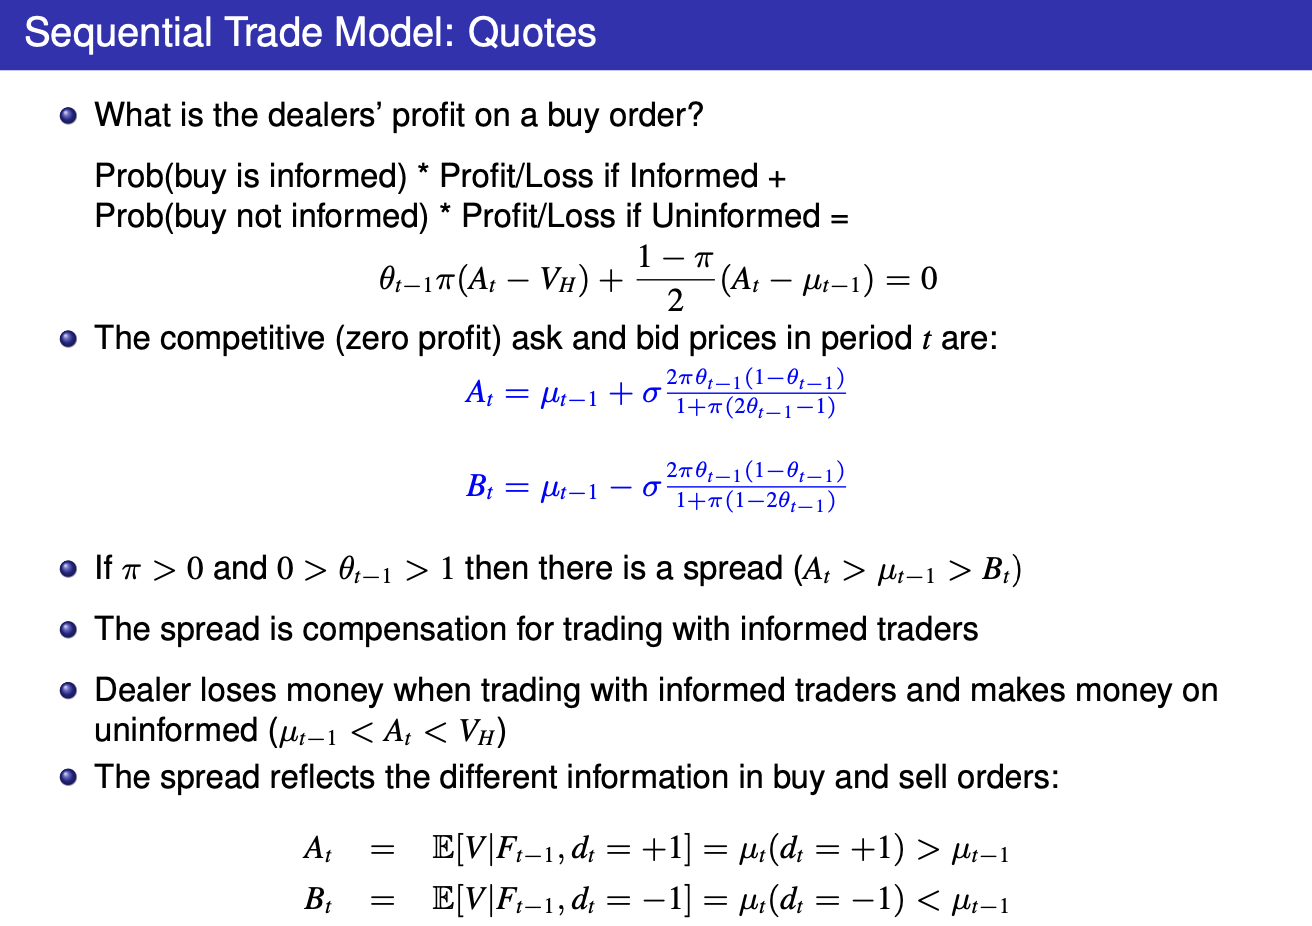

In [ ]:
msft_df.ts_recv = pd.to_datetime(msft_df.ts_recv)
msft_df.set_index('ts_recv', inplace = True)
msft_df.ts_event = pd.to_datetime(msft_df.ts_event)

In [ ]:
### proportion of inform traders

PI = 0.15

### last transactions window
ROLLING = 20

###### Quote algorithm ######

''' this algorithm offers a highly simplified approach to quote bid and ask processing. 
I've made a lot of assumptions to make the quote process possible. Feel free to modify this code
Every time there is a new trade a propose a new quote
'''


def get_quotes(df):
    df_trade = df[df.action == 'T']
    ### mu_t_1 is the last update
    df_trade.loc[:,['mu_t_1']] = df_trade.loc[:,'price'].shift(1)
    df_trade.loc[:,['sigma']] = df_trade.loc[:,'price'].rolling(ROLLING).std()
    df_trade.loc[:,['monotony']] = (np.sign(df_trade.loc[:,'price'].pct_change()).replace(0)+1)/2
    df_trade.loc[:,['theta']]= df_trade.loc[:,'monotony'].rolling(ROLLING).mean()

    #Proportion of inform trader
    pi = PI

    df_trade.loc[:,['A_T']] = df_trade.mu_t_1 + df_trade.sigma*2*pi*df_trade.theta.shift(1)*(1-df_trade.theta.shift(1))/\
        (1+pi*(2*df_trade.theta.shift(1)-1))
    df_trade.loc[:,['B_T']] = df_trade.mu_t_1 - df_trade.sigma*2*pi*df_trade.theta.shift(1)*(1-df_trade.theta.shift(1))/\
         (1-pi*(2*df_trade.theta.shift(1)-1))
    
    df_quote = df.join(df_trade[['B_T','A_T']],how='left')
    df_quote.sort_index(inplace = True)
    df_quote.A_T.ffill(inplace = True)
    df_quote.B_T.ffill(inplace = True)
    return df_quote,df_trade


df_trade = msft_df.reset_index()
df_trade = df_trade[df_trade.action == 'T']

df_quote,df_trade2 = get_quotes(msft_df.reset_index())
df_quote

,ts_recv,ts_event,action,side,depth,price,size,flags,bid_px_00,ask_px_00,...,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,B_T,A_T
0,2023-05-08 08:00:00.004198291+00:00,2023-05-08 08:00:00.004032027+00:00,A,N,0,310.11,200,130,310.11,NaN,...,0,0,NaN,NaN,0,0,0,0,NaN,NaN
1,2023-05-08 08:00:00.030510300+00:00,2023-05-08 08:00:00.030343750+00:00,A,N,0,340.00,100,130,310.11,340.00,...,0,0,NaN,NaN,0,0,0,0,NaN,NaN
2,2023-05-08 08:00:00.038177709+00:00,2023-05-08 08:00:00.038013076+00:00,A,N,1,308.00,40,130,310.11,340.00,...,0,0,NaN,NaN,0,0,0,0,NaN,NaN
3,2023-05-08 08:00:00.084292335+00:00,2023-05-08 08:00:00.084127822+00:00,A,N,1,310.10,17,130,310.11,340.00,...,0,0,NaN,NaN,0,0,0,0,NaN,NaN
4,2023-05-08 08:00:00.089263899+00:00,2023-05-08 08:00:00.089099983+00:00,C,N,0,310.11,200,130,310.10,340.00,...,0,0,NaN,NaN,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1762201,2023-05-08 23:59:45.488743225+00:00,2023-05-08 23:59:45.488579844+00:00,C,N,1,307.86,4,130,307.70,307.85,...,1,1,306.5,308.88,255,11,3,2,307.834437,307.846274
1762202,2023-05-08 23:59:45.537828107+00:00,2023-05-08 23:59:45.537664286+00:00,A,N,3,308.37,4,130,307.70,307.85,...,1,1,306.5,308.83,255,1,3,1,307.834437,307.846274
1762203,2023-05-08 23:59:50.129508455+00:00,2023-05-08 23:59:50.129344727+00:00,C,N,3,308.37,4,130,307.70,307.85,...,1,1,306.5,308.88,255,11,3,2,307.834437,307.846274
1762204,2023-05-08 23:59:50.174364332+00:00,2023-05-08 23:59:50.174200608+00:00,A,N,3,308.34,4,130,307.70,307.85,...,1,1,306.5,308.83,255,1,3,1,307.834437,307.846274


                                    ts_recv  \
0       2023-05-08 08:00:00.004198291+00:00   
1       2023-05-08 08:00:00.030510300+00:00   
2       2023-05-08 08:00:00.038177709+00:00   
3       2023-05-08 08:00:00.084292335+00:00   
4       2023-05-08 08:00:00.089263899+00:00   
...                                     ...   
1762201 2023-05-08 23:59:45.488743225+00:00   
1762202 2023-05-08 23:59:45.537828107+00:00   
1762203 2023-05-08 23:59:50.129508455+00:00   
1762204 2023-05-08 23:59:50.174364332+00:00   
1762205 2023-05-08 23:59:51.022320369+00:00   

                                   ts_event action side  depth   price  size  \
0       2023-05-08 08:00:00.004032027+00:00      A    N      0  310.11   200   
1       2023-05-08 08:00:00.030343750+00:00      A    N      0  340.00   100   
2       2023-05-08 08:00:00.038013076+00:00      A    N      1  308.00    40   
3       2023-05-08 08:00:00.084127822+00:00      A    N      1  310.10    17   
4       2023-05-08 08:00:00.0890999

In [ ]:
df_trade2.dropna()[['ts_event','price','action','bid_px_01','bid_px_00','ask_px_00','ask_px_01','B_T','A_T']]

,ts_event,price,action,bid_px_01,bid_px_00,ask_px_00,ask_px_01,B_T,A_T
476,2023-05-08 08:02:26.367619414+00:00,310.20,T,310.11,310.12,310.60,310.62,310.545795,310.574205
530,2023-05-08 08:03:30.856155641+00:00,310.26,T,310.10,310.11,310.59,310.62,310.185468,310.214532
531,2023-05-08 08:03:30.856155641+00:00,310.11,T,310.10,310.11,310.59,310.62,310.244093,310.275437
532,2023-05-08 08:03:30.856155641+00:00,310.11,T,310.00,310.10,310.59,310.62,310.093767,310.126233
545,2023-05-08 08:03:30.862622762+00:00,310.10,T,310.00,310.10,310.59,310.62,310.092640,310.127360
...,...,...,...,...,...,...,...,...,...
1762053,2023-05-08 23:51:37.146945239+00:00,307.59,T,307.50,307.59,307.62,307.84,307.596602,307.604070
1762078,2023-05-08 23:51:37.165967188+00:00,307.59,T,307.50,307.59,307.62,307.84,307.586511,307.594179
1762109,2023-05-08 23:53:51.771030792+00:00,307.65,T,307.50,307.59,307.65,307.71,307.586543,307.594141
1762169,2023-05-08 23:59:03.731584061+00:00,307.84,T,307.50,307.59,307.84,307.85,307.645496,307.655235


                                   ts_event   price action  bid_px_01  \
476     2023-05-08 08:02:26.367619414+00:00  310.20      T     310.11   
530     2023-05-08 08:03:30.856155641+00:00  310.26      T     310.10   
531     2023-05-08 08:03:30.856155641+00:00  310.11      T     310.10   
532     2023-05-08 08:03:30.856155641+00:00  310.11      T     310.00   
545     2023-05-08 08:03:30.862622762+00:00  310.10      T     310.00   
...                                     ...     ...    ...        ...   
1762053 2023-05-08 23:51:37.146945239+00:00  307.59      T     307.50   
1762078 2023-05-08 23:51:37.165967188+00:00  307.59      T     307.50   
1762109 2023-05-08 23:53:51.771030792+00:00  307.65      T     307.50   
1762169 2023-05-08 23:59:03.731584061+00:00  307.84      T     307.50   
1762195 2023-05-08 23:59:30.678106951+00:00  307.85      T     307.50   

         bid_px_00  ask_px_00  ask_px_01         B_T         A_T  
476         310.12     310.60     310.62  310.545795  31

## 1 - 2  Avellaneda and Stoikov Model

In [ ]:
# Marco Avellaneda & Sasha Stoikov

def real_quote(quote, tick=0.01): 
    #q= (quote/tick).apply(lambda x: np.round(x))
    q= (quote/tick).round()
    return  tick * q
    


def quote_SA(df_order_book,q,qmax,limit_horizon = True, gamma = 0.1, k = 1.5,tick = 0.01,alpha=1):
    ''' This algo give bid and ask quote based on the Sasha Stoikov and Marco Avellaneda Model
    
    Input: 
    • df_order_book: pandas dataframe = orderbook 
    
    • q = current position,
    
    • qmax = maximum position,
    
    • limit_horizon = True, There is two approach in this model, you want 
                            to maximize your utility either end until a point in time or 
                            until an infinite horizon. 
                            True --> finite horizon
                            False --> infinite horizon
    
    • gamma = 0.1, risk aversion parameter
    
    • k = 1.5, Market model parameter
    
    • tick = 0.01, tick size
    
    Output:
    
    None but add bid and ask to the order book 
    
    
    '''

    if 'mid_price' not in df_order_book.columns:
        df_order_book.loc[:,'mid_price'] = (df_order_book.loc[:,'bid_px_00']+df_order_book.loc[:,'ask_px_00'])/2
    if q == None: 
        q = qmax

    # Risk factor (->0: high risk, ->1: low risk)
    gamma = 0.1

    # Market model
    k = 1.5

    #tick size
    tick = 0.01

    s = df_order_book['mid_price'].copy()

    sigma = df_order_book['mid_price'].rolling(1000).std()

    ###############
    # Option A: limit time horizon
    if limit_horizon:
        T = 1 
        N = s.shape[0]-1
        dt = T/N
        t = numpy.linspace(0.0, N*dt, N+1)

        # Reserve price
        r = s - q * gamma * sigma**2 * (T-t)

        # Reserve spread
        r_spread = 2 / gamma * np.log(1+gamma/k)    

        # optimal quotes
        ra = real_quote(r + r_spread/2,tick = tick)
        rb = real_quote(r - r_spread/2,tick = tick)

    ###############
    # Option B: Unlimit time horizon
    else:
        
        # Upper bound of inventory position
        w = 0.5 * gamma**2 * sigma**2 * (q_max+alpha)**2

        # Optimal quotes
        coef = gamma**2*sigma**2/(2*w-gamma**2*q**2*sigma**2)
        ra = real_quote(s + np.log(1+(1-2*q)*coef)/gamma,tick = tick)
        rb = real_quote(s + np.log(1+(-1-2*q)*coef)/gamma,tick = tick)
        
    df_order_book.loc[:,'ask'] = ra
    df_order_book.loc[:,'bid'] = rb

<Figure size 1500x1500 with 0 Axes>

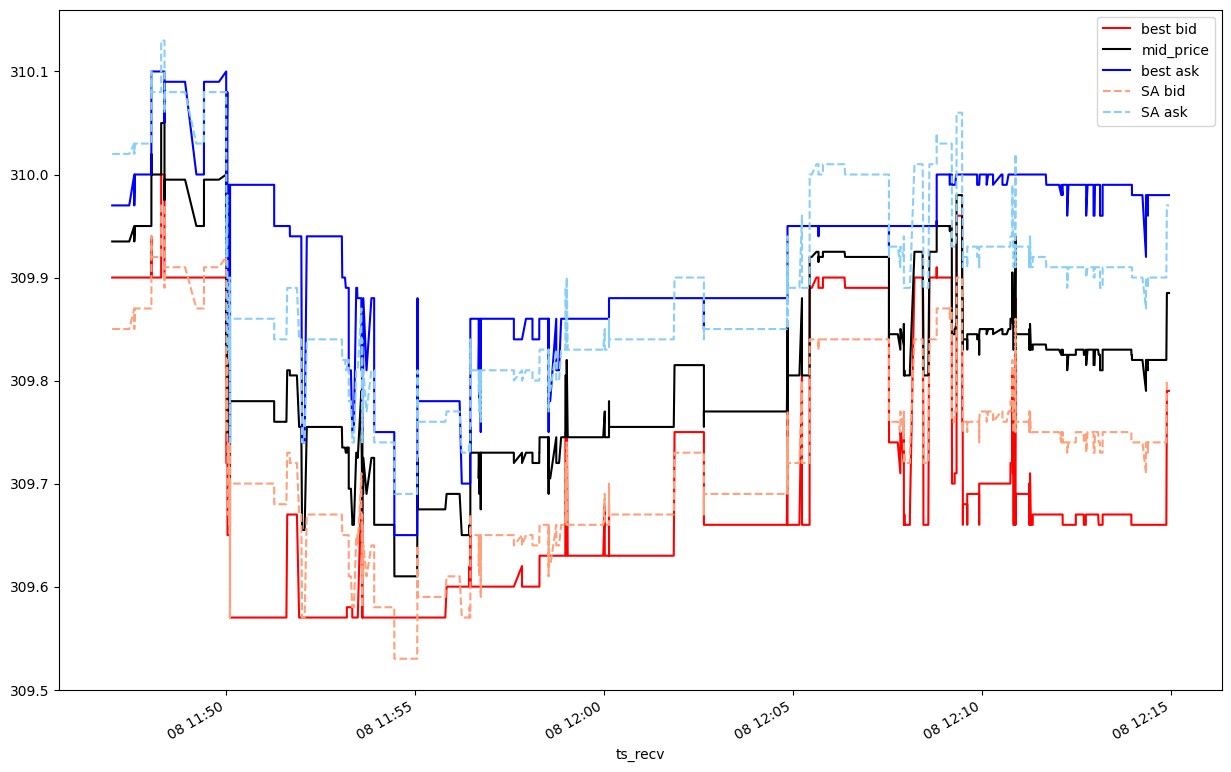

<Figure size 1500x1000 with 1 Axes>

In [ ]:
quote_SA(msft_df,0,10,limit_horizon = False, gamma = 0.1, k = 1.5,tick = 0.01)
plt.figure(figsize=(15,15))
msft_df[['bid_px_00','mid_price',"ask_px_00",'bid','ask']].iloc[10000:12000,:].plot(color = ['red','black','blue','lightsalmon','lightskyblue']\
                                                                                    ,figsize=(15,10)\
                                                                                    ,style=['-', '-', '-','--','--'])
plt.legend(['best bid','mid_price',"best ask",'SA bid','SA ask'])
plt.show()

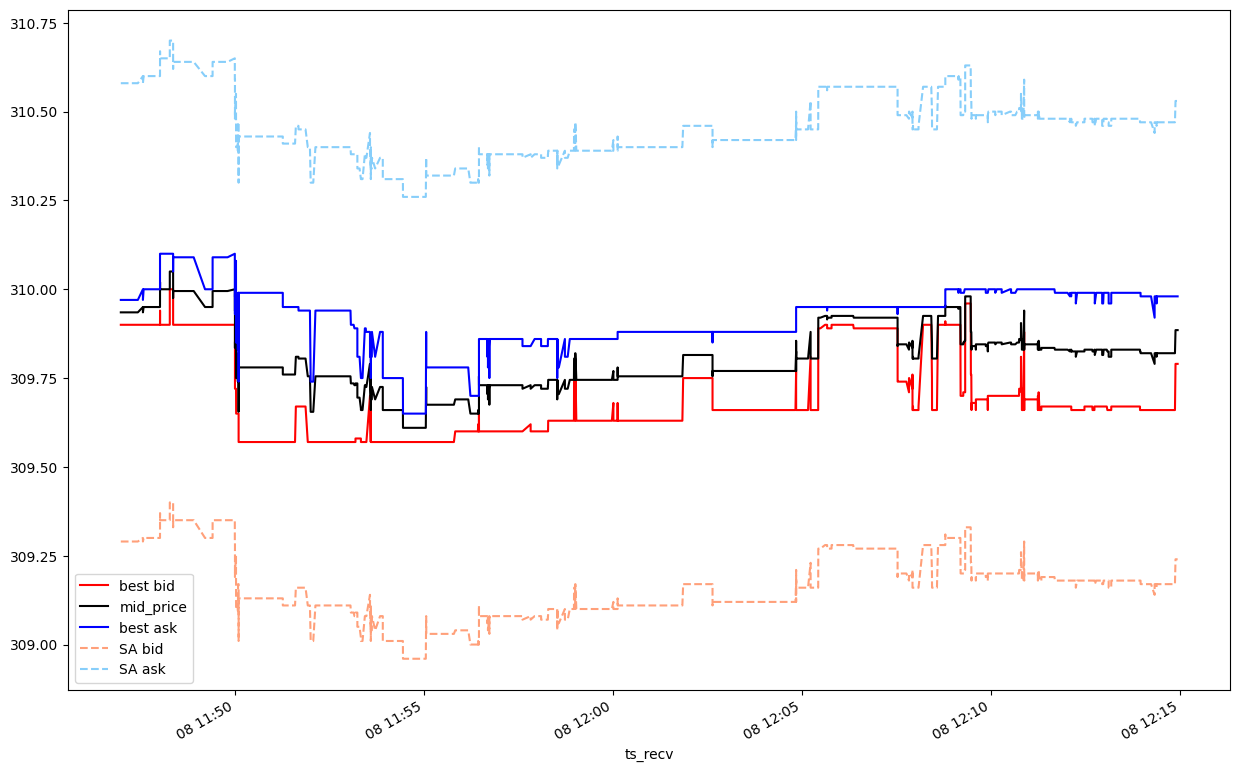

<Figure size 1500x1000 with 1 Axes>

In [ ]:
quote_SA(msft_df,0,10,limit_horizon = True, gamma = 0.1, k = 1.5,tick = 0.01)

msft_df[['bid_px_00','mid_price',"ask_px_00",'bid','ask']].iloc[10000:12000,:].plot(color = ['red','black','blue','lightsalmon','lightskyblue']\
                                                                                    ,figsize=(15,10)\
                                                                                    ,style=['-', '-', '-','--','--'])
plt.legend(['best bid','mid_price',"best ask",'SA bid','SA ask'])
plt.show()

# this is too large I need to work on that 

### 1-2-1 Evolution of the quote across inventory $q$ and the hyper-paramter $\alpha$

### Infinite  Horizon

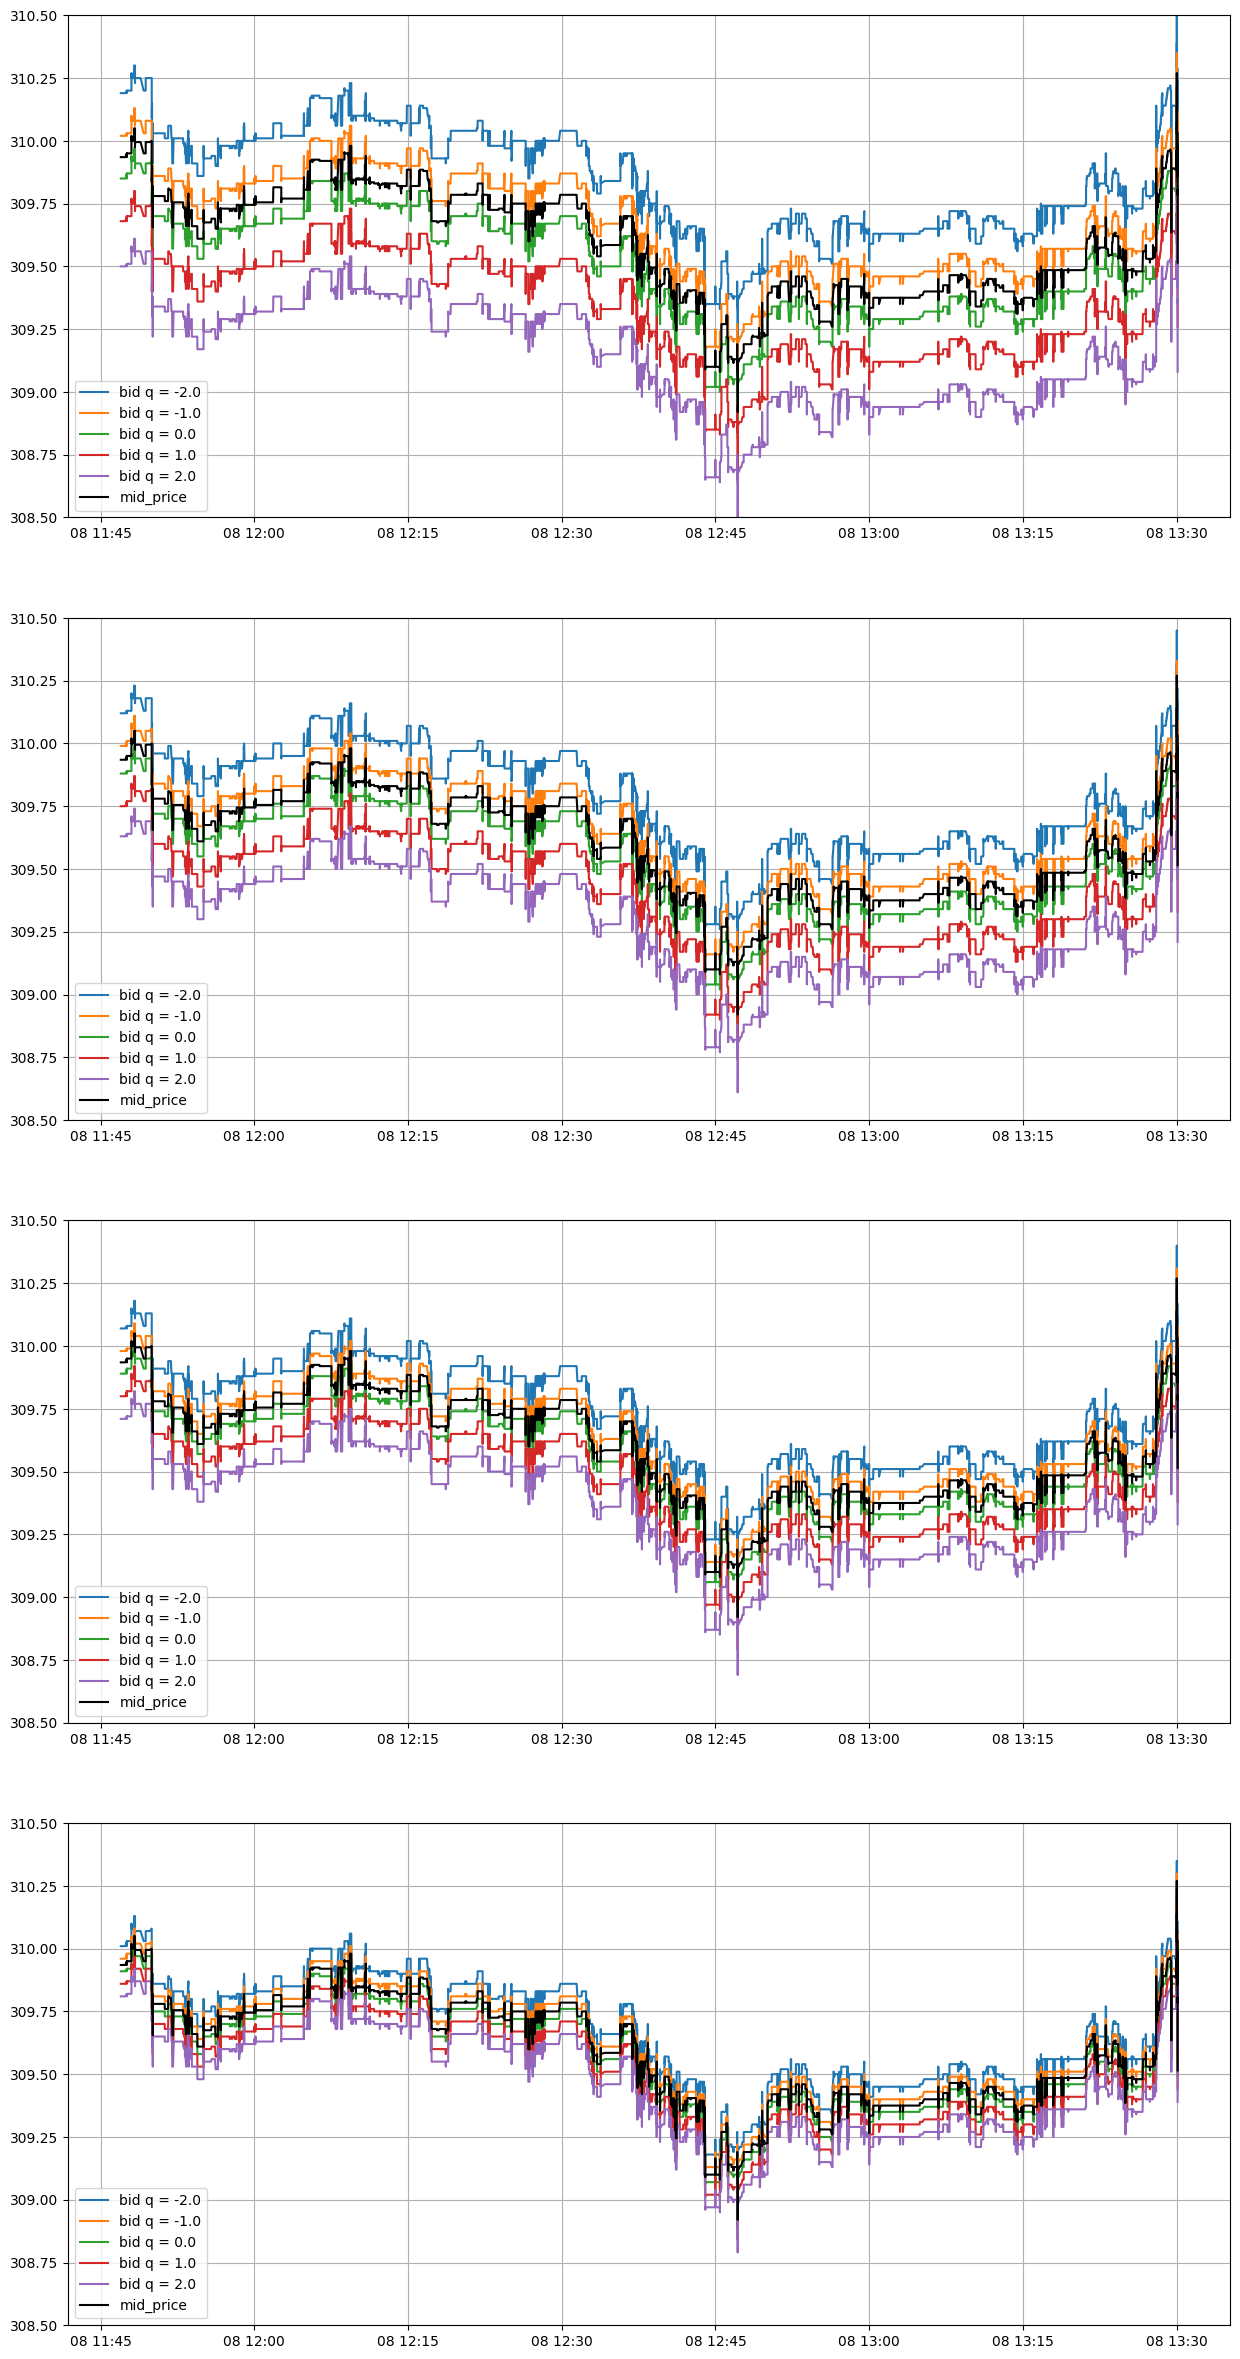

<Figure size 1500x3000 with 4 Axes>

In [ ]:
test_alpha = [1,3,5,10]
nb_alpha = len(test_alpha)
nb_q = 2
fig, ax = plt.subplots(nb_alpha,1, figsize=(15, 30))
for ind_alpha, alpha in enumerate(test_alpha):
    for q in np.linspace(-nb_q,nb_q,2*nb_q+1):
        quote_SA(msft_df,q,10,limit_horizon = False, gamma = 0.1, k = 1.5,tick = 0.01, alpha = alpha)
        ax[ind_alpha].plot(msft_df[['bid']].iloc[10000:20000,:],label = 'bid q = ' + str(q))
        ax[ind_alpha].grid()
        
    ax[ind_alpha].plot(msft_df[['mid_price']].iloc[10000:20000,:],label = 'mid_price',color ='black')
    ax[ind_alpha].set_ylim([308.5,310.5])
    ax[ind_alpha].legend()
    

### limit Horizon

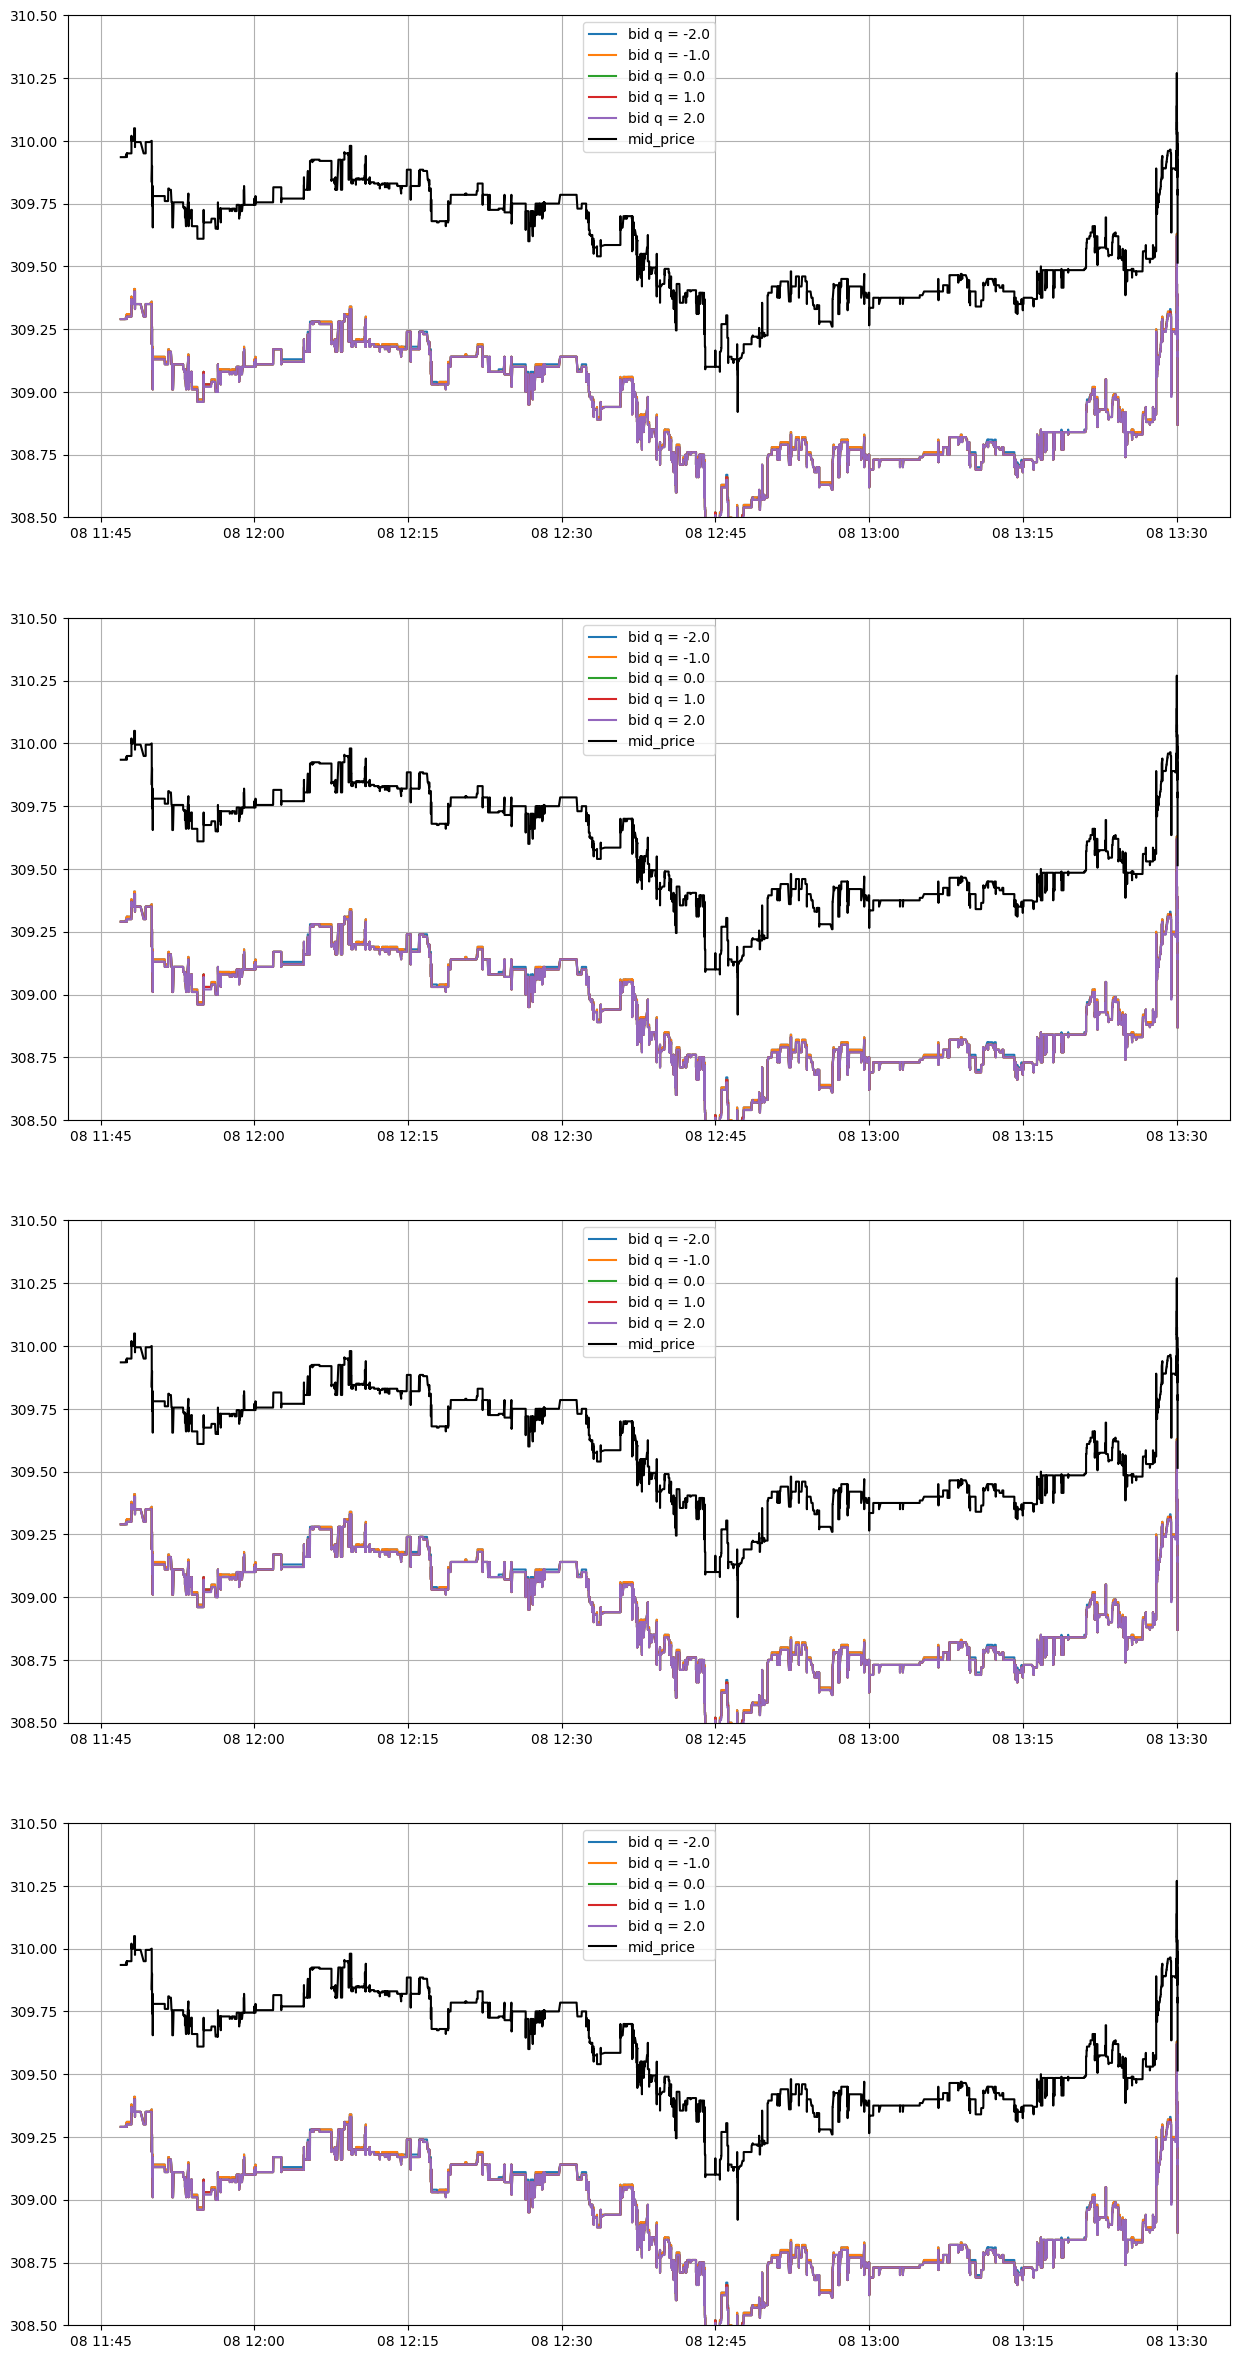

<Figure size 1500x3000 with 4 Axes>

In [ ]:
test_alpha = [1,3,5,10]
nb_alpha = len(test_alpha)
nb_q = 2
fig, ax = plt.subplots(nb_alpha,1, figsize=(15, 30))
for ind_alpha, alpha in enumerate(test_alpha):
    for q in np.linspace(-nb_q,nb_q,2*nb_q+1):
        quote_SA(msft_df,q,10,limit_horizon = True, gamma = 0.1, k = 1.5,tick = 0.01, alpha = alpha)
        ax[ind_alpha].plot(msft_df[['bid']].iloc[10000:20000,:],label = 'bid q = ' + str(q))
        ax[ind_alpha].grid()
        
    ax[ind_alpha].plot(msft_df[['mid_price']].iloc[10000:20000,:],label = 'mid_price',color ='black')
    ax[ind_alpha].set_ylim([308.5,310.5])
    ax[ind_alpha].legend()